# Multiclass Bayes Filter

In [2]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

In [11]:
class SimpleBayesFilter(object):
    
    def __init__(self, n, M):       
        self.M = M
        self.stateList = []
        for i in range(n):
            theta = [np.random.uniform(-3, 3),1]#TODO
            self.stateList.append(self.initState(1.0/n, theta))
        
    def initState(self, z, theta):
        return {'z':z, 'theta':theta, 'likelihood': [theta[0],1]}
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def update(self, _x): 
        zSum = 0
        zMax = 0
        zMaxIndex = -1
        for i,s in enumerate(self.stateList):
            likelihood = scipy.stats.norm(s['likelihood'][0], s['likelihood'][1]).pdf(_x)
            transitionProb = 0
            for k,j in enumerate(self.M[:,i]):
                transitionProb +=  self.stateList[k]['z'] * j.item(0)
            unnormZ = likelihood * transitionProb
            s['unnormZ'] = unnormZ
            zSum += unnormZ
            #finding maximum z
            if unnormZ > zMax:
                zMax = unnormZ
                zMaxIndex = i
        
        #normalising z
        for s in self.stateList:
            s['z'] = s['unnormZ']/zSum
            #print "s['z']", s['z']
        #update state of zMax
        if(zMaxIndex > -1):
            self.stateList[zMaxIndex]['theta'] = self.computeTheta(_x, self.stateList[zMaxIndex]['theta'])
            self.stateList[zMaxIndex]['likelihood'][0] = self.stateList[zMaxIndex]['theta'][0]

        
        return self.stateList
    #self.z, self.theta0, self.theta1

In [4]:
class SimpleBayesFilterWithPrior(object):
    
    def __init__(self, n, M):

        
        
        self.M = M

        self.stateList = []
        for i in range(n):
            theta = [np.random.uniform(-5, 5),1]#TODO
            self.stateList.append(self.initState(1.0/n, theta))
        
    def initState(self, z, theta):
        return {'z':z, 'theta':theta, 'likelihood': [theta[0],1], 'count': 0, 'sum': 0}
        
    def computeTheta(self, _x, _theta, _sum, _count):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + _count/1.0)# maybe find a better way for the likelihood var = 1
        #compute updated mean
        theta[0] = (((1.0 * theta[0]) / theta[1]) + _sum/theta[1])/(1.0/theta[1] + _count/theta[1])
        return theta
    
    def update(self, _x): 
        zSum = 0
        zMax = 0
        zMaxIndex = -1
        for i,s in enumerate(self.stateList):
            likelihood = scipy.stats.norm(s['likelihood'][0], s['likelihood'][1]).pdf(_x)
            prior = scipy.stats.norm(s['theta'][0], s['theta'][1]).pdf(s['likelihood'][0])
            transitionProb = 0
            for k,j in enumerate(self.M[:,i]):
                transitionProb +=  self.stateList[k]['z'] * j.item(0)
            unnormZ = likelihood * transitionProb * prior
            s['unnormZ'] = unnormZ
            zSum += unnormZ
            #finding maximum z
            if unnormZ > zMax:
                zMax = unnormZ
                zMaxIndex = i
        
        #normalising z
        for s in self.stateList:
            s['z'] = s['unnormZ']/zSum
            #print "s['z']", s['z']
        #update state of zMax
        if(zMaxIndex > -1):
            self.stateList[zMaxIndex]['sum'] += _x
            self.stateList[zMaxIndex]['count'] += 1
            self.stateList[zMaxIndex]['theta'] = self.computeTheta(_x, self.stateList[zMaxIndex]['theta'], 
                                                                   self.stateList[zMaxIndex]['sum'], 
                                                                   self.stateList[zMaxIndex]['count'])#TODO
            self.stateList[zMaxIndex]['likelihood'][0] = self.stateList[zMaxIndex]['theta'][0]

        
        return self.stateList
    #self.z, self.theta0, self.theta1

In [6]:
def TestData(mean=[4, -4, 0], var=[1, 1, 1.3], n=10, skips=5):
    groundTruth = np.full(n,1)
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%len(mean)],var[i%len(mean)],n))
        groundTruth = np.append(groundTruth, np.full(n,i%len(mean)))
    return data, groundTruth, mean

In [7]:
def plotFilterData(data, filterData):
    z = []
    mean = []
    var = []
    n = len(filterData[0])
    for i in range(n):
        z.append([])
        mean.append([])
        var.append([])
    for x in filterData:
        for i in range(n):
            z[i].append(x[i]['z'])
            mean[i].append(x[i]['theta'][0])
            var[i].append(x[i]['theta'][1])
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    for i in range(n):
        ax1.plot(range(len(filterData)), z[i])  
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(range(len(data)), data, 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()
    
    for i in range(n):
        plt.plot(mean[i])
    plt.scatter(range(len(data)),data, color='red')
    plt.title('mean of the states')
    plt.show()

    for i in range(n):
        plt.plot(var[i])
    plt.title('variance of the states')
    plt.show


In [8]:
def falsePositiveEval(truth, filterData, means):
    correctPred = 0 
    falsePred = 0
    mapping = findMapping(truth, filterData[-1], means)
    for i,d in enumerate(filterData):
        pred = -1
        zMax = -1        
        for truthI, predI in enumerate(mapping):
            z = d[predI]['z']
            if z > zMax:
                zMax = z
                pred = truthI
        if  pred == truth[i]:
            correctPred += 1
        else:
            falsePred += 1
    if correctPred+falsePred != len(truth):
        print 'something is fishy'
    print 'True Positive', correctPred
    print 'false Posiive', falsePred
    return correctPred, falsePred

def findMapping(truth, filterData, means):
    filterMeans = []
    mapping = []
    for i in filterData:
        filterMeans.append(i['theta'][0])
    for i in range(len(means)):
        fMeansSub = copy.deepcopy(filterMeans)
        for j in range(len(fMeansSub)):
            fMeansSub[j] = abs(fMeansSub[j] - means[i])
        index = np.argmin(fMeansSub)
        mapping.append(index)
    print 'true means', means
    print 'prediction means', filterMeans
    print mapping
    return mapping

/home/arne/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(30, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/arne/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(30, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


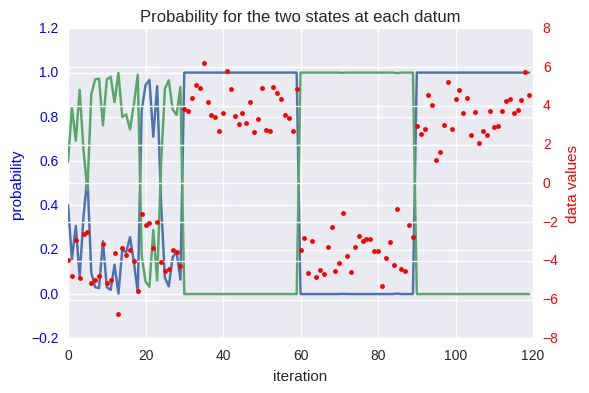

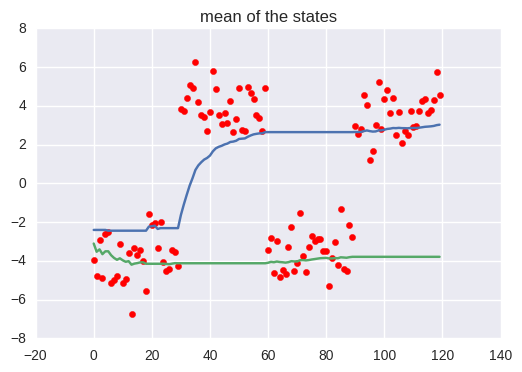

true means [4, -4]
prediction means [3.0238356543659175, -3.7951951991073822]
[0, 1]
True Positive 114
false Posiive 6


(114, 6)

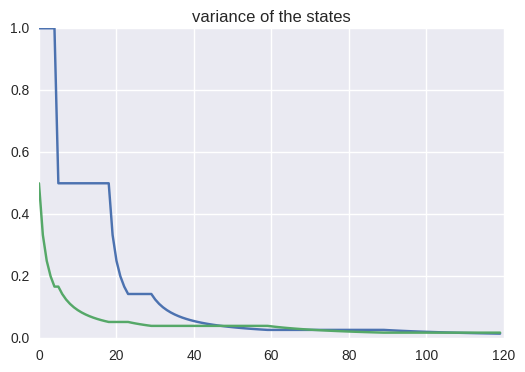

In [173]:
data, groundTruth, means = TestData(skips=3, n=30, mean=[4, -4], var=[1, 1])
fA = SimpleBayesFilter2(2, np.matrix([[0.8, 0.2],[ 0.2, 0.8]]))
filterData = []
for x in data:
    d = copy.deepcopy(fA.update(x))
    filterData.append(d)
plotFilterData(data, filterData)
falsePositiveEval(groundTruth, filterData, means)

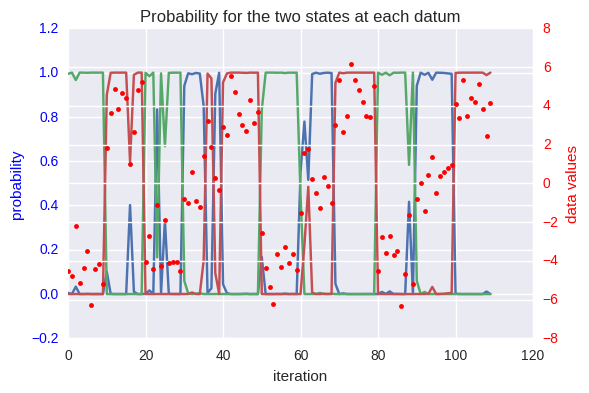

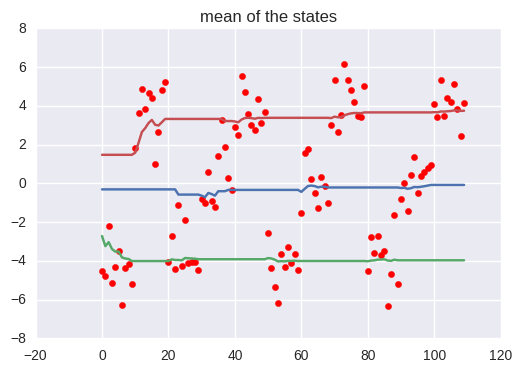

true means [4, -4, 0]
prediction means [-0.085235254779159553, -3.9753571904688743, 3.7437375443505219]
[2, 1, 0]
True Positive 106
false Posiive 4


(106, 4)

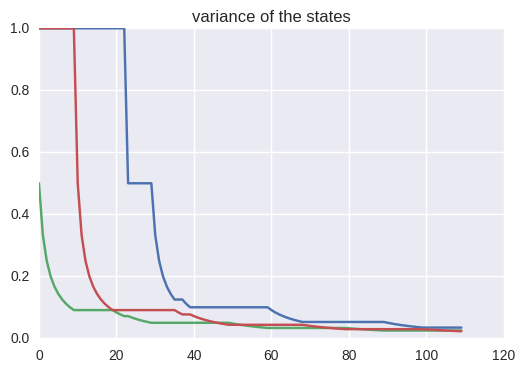

In [10]:
data, groundTruth, means = TestData(skips=10, n=10)
fA = SimpleBayesFilter2(3, np.matrix([[0.8, 0.1, 0.1],[0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]))
filterData = []
for x in data:
    d = copy.deepcopy(fA.update(x))
    filterData.append(d)
plotFilterData(data, filterData)
falsePositiveEval(groundTruth, filterData, means)